# Makine Öğrenmesi İle Sahte Haber Tespiti


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import re
import string

## Verisetini Okuma

In [4]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [5]:
fake.shape

(23481, 4)

In [6]:
true.shape

(21417, 4)

In [7]:
fake["class"] = 0
true["class"] = 1

## Veri Temizleme ve Hazırlama

In [8]:
# Sahte ve gerçek haberleri takip edebilmek için flag koyuyoruz.
fake['targets'] = 'fake'
true['targets'] = 'true'

In [9]:
# verileri birleştirelim
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape
data.isnull().sum()

title      0
text       0
subject    0
date       0
class      0
targets    0
dtype: int64

In [8]:
# verileri random karıştıralım
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [9]:
data.head()

,title,text,subject,date,class,targets
0,ENABLERS WHO LIVE IN GLASS HOUSES…Why Hillary ...,The woman whose husband made several trips to ...,left-news,"Sep 28, 2016",0,fake
1,Watch as Trump Gatecrashes Glenn Beck’s Cruz C...,21st Century Wire says One TV personality Tru...,US_News,"February 24, 2016",0,fake
2,Panama Papers Show Donald Trump’s Name Mentio...,The Panama Papers recently exposed the worst o...,News,"May 14, 2016",0,fake
3,Former CIA/NSA Chief Says Trump’s Unlawful Or...,Donald Trump has this tough guy syndrome that ...,News,"February 27, 2016",0,fake
4,Rebel area near Damascus hit by heavy shelling...,BEIRUT (Reuters) - Dozens of mortar bombs land...,worldnews,"November 29, 2017",1,true


In [10]:
# date sütununa ihtiyacımız olmadığı için silelim
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,class,targets
0,ENABLERS WHO LIVE IN GLASS HOUSES…Why Hillary ...,The woman whose husband made several trips to ...,left-news,0,fake
1,Watch as Trump Gatecrashes Glenn Beck’s Cruz C...,21st Century Wire says One TV personality Tru...,US_News,0,fake
2,Panama Papers Show Donald Trump’s Name Mentio...,The Panama Papers recently exposed the worst o...,News,0,fake
3,Former CIA/NSA Chief Says Trump’s Unlawful Or...,Donald Trump has this tough guy syndrome that ...,News,0,fake
4,Rebel area near Damascus hit by heavy shelling...,BEIRUT (Reuters) - Dozens of mortar bombs land...,worldnews,1,true


In [11]:
# sadece haber içeriğini kullanacağımız için başlığı da silebiliriz.
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,class,targets
0,The woman whose husband made several trips to ...,left-news,0,fake
1,21st Century Wire says One TV personality Tru...,US_News,0,fake
2,The Panama Papers recently exposed the worst o...,News,0,fake
3,Donald Trump has this tough guy syndrome that ...,News,0,fake
4,BEIRUT (Reuters) - Dozens of mortar bombs land...,worldnews,1,true


In [12]:
# cümleleri küçük harflerle yazalım
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,class,targets
0,the woman whose husband made several trips to ...,left-news,0,fake
1,21st century wire says one tv personality tru...,US_News,0,fake
2,the panama papers recently exposed the worst o...,News,0,fake
3,donald trump has this tough guy syndrome that ...,News,0,fake
4,beirut (reuters) - dozens of mortar bombs land...,worldnews,1,true


In [13]:
# noktalama işaretlerini de kaldıralım.

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [14]:
# kontrol edelim
data.head()

,text,subject,class,targets
0,the woman whose husband made several trips to ...,left-news,0,fake
1,21st century wire says one tv personality tru...,US_News,0,fake
2,the panama papers recently exposed the worst o...,News,0,fake
3,donald trump has this tough guy syndrome that ...,News,0,fake
4,beirut reuters dozens of mortar bombs landed ...,worldnews,1,true


In [42]:
df = data.copy()
df.head()

,text,subject,class,targets
0,woman whose husband made several trips pedophi...,left-news,0,fake
1,21st century wire says one tv personality trum...,US_News,0,fake
2,panama papers recently exposed worst worst wor...,News,0,fake
3,donald trump tough guy syndrome makes impossib...,News,0,fake
4,beirut reuters dozens mortar bombs landed last...,worldnews,1,true


In [43]:
df.to_csv("new_data.csv",index=False)

In [15]:
# etkisiz kelimeleri (stopwords) kaldıralım.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [16]:
data.head()

,text,subject,class,targets
0,woman whose husband made several trips pedophi...,left-news,0,fake
1,21st century wire says one tv personality trum...,US_News,0,fake
2,panama papers recently exposed worst worst wor...,News,0,fake
3,donald trump tough guy syndrome makes impossib...,News,0,fake
4,beirut reuters dozens mortar bombs landed last...,worldnews,1,true


## Temel Verileri Bulma

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


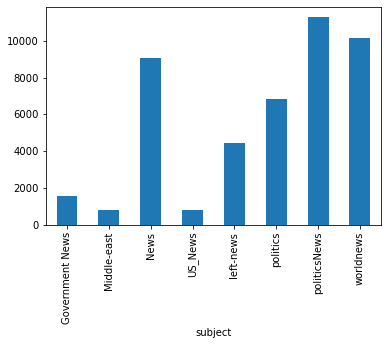

In [17]:
# hangi konudan kaç makale var bulalım. 
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

targets
fake    23481
true    21417
Name: text, dtype: int64


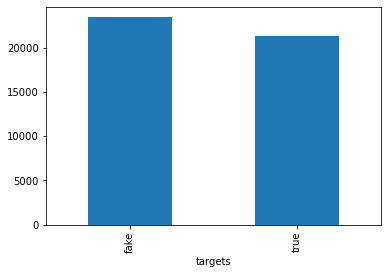

In [18]:
# Makalelerin ne kadarı gerçek/sahte bakalım
print(data.groupby(['targets'])['text'].count())
data.groupby(['targets'])['text'].count().plot(kind="bar")
plt.show()

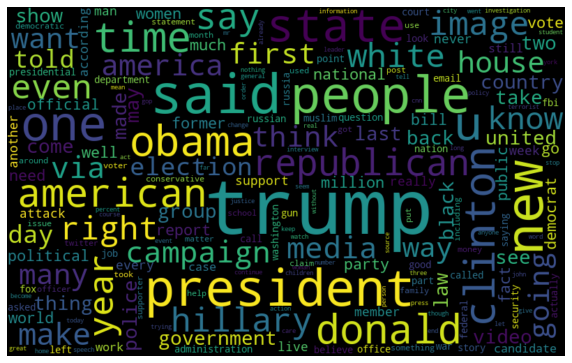

In [19]:
# Sahte haberler için WordCloud (kelime bulutu)
from wordcloud import WordCloud

fake_data = data[data["targets"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

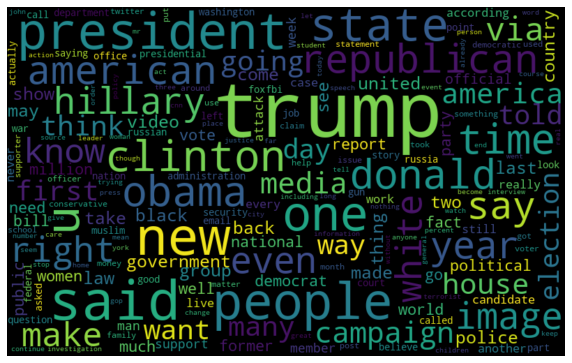

In [20]:
# Gerçek haberler için WorldCloud
from wordcloud import WordCloud

real_data = data[data["targets"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
# En sık kullanılan kelimelere bakalım 
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

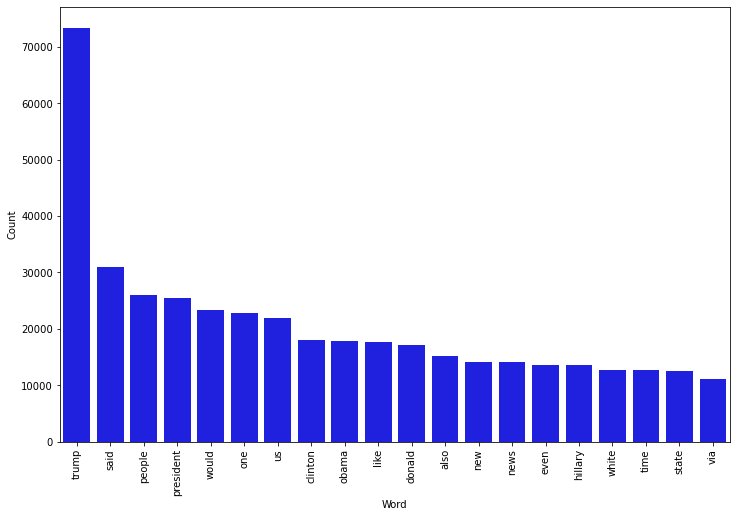

In [22]:
# Sahte haberlerde en sık kullanılan kelimeler
counter(data[data["targets"] == "fake"], "text", 20)

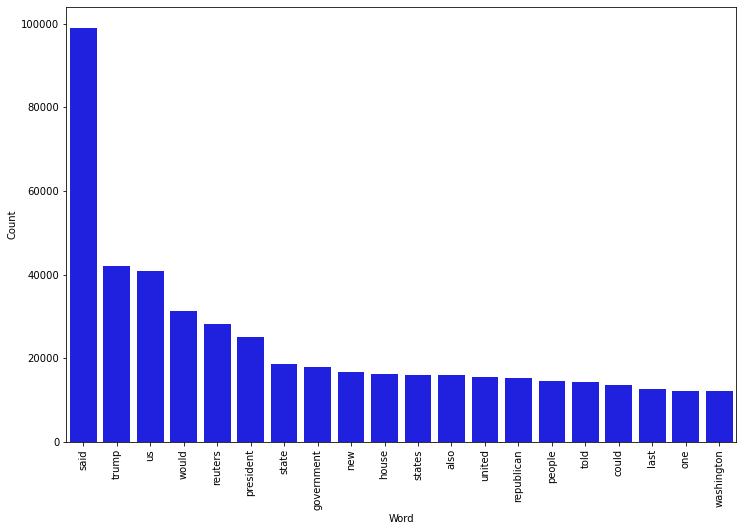

In [23]:
# Gerçek haberlerde en sık kullanılan kelimeler
counter(data[data["targets"] == "true"], "text", 20)

## Verinin Modellenmesi

In [24]:
# Karışıklık matrisini çizdirelim (confusion matrix) 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Veriyi Hazırlama

In [25]:
# Veriyi eğitim ve test olarak ayıralım
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.targets, test_size=0.2, random_state=42)

# **Naive Bayes Algoritması**




###### TD-IDF sözcüğün bulunduğu dökümanı ne kadar temsil ettiğini gösteren bir istatistiksel değerdir.

In [26]:
#Bayes kullanarak veriyi sınıflandıralım
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])
#modeli eğitelim
model = pipe.fit(X_train, y_train)
#doğruluk
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.08%


Confusion matrix, without normalization


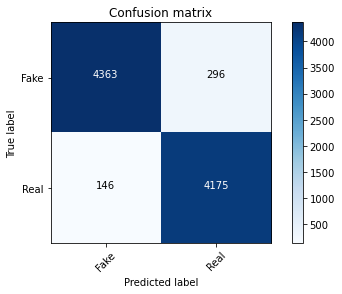

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Lojistik regression kullanarak veri kümesini analiz etme**

In [28]:
# TF-IDF yi vektörleştirme
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# modeli eğitelim
model = pipe.fit(X_train, y_train)

# Doğruluk
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.79%


Confusion matrix, without normalization


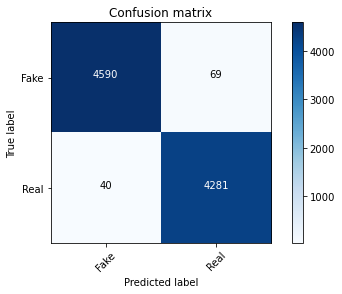

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Karar Ağacı Algoritması (Decision Tree)**

In [30]:
from sklearn.tree import DecisionTreeClassifier

# TF-IDF yi vektörleştirme
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Modeli eğitelim
model = pipe.fit(X_train, y_train)

# doğruluk oranı
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.69%


Confusion matrix, without normalization


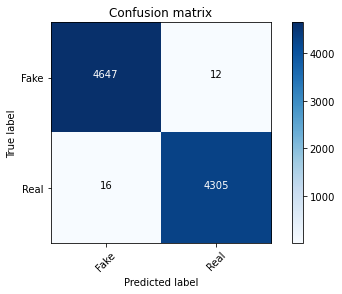

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest Algoritması**

In [32]:
from sklearn.ensemble import RandomForestClassifier
#TF-IDF yi vektörleştirme
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
#Modeli Eğitme
model = pipe.fit(X_train, y_train)
#Doğruluğu
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.16%


Confusion matrix, without normalization


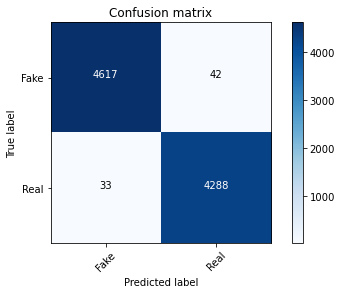

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM Algoritması**

In [34]:
from sklearn import svm

#SVM sınıflandırıcısı oluşturma
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])
#Modeli Eğitme
model = pipe.fit(X_train, y_train)
#Doğruluk oranı
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.53%


Confusion matrix, without normalization


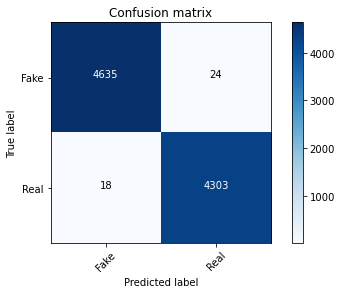

In [35]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Farklı Modellerin Karşılaştırılması**

([<matplotlib.axis.YTick at 0x16a0cdbefd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

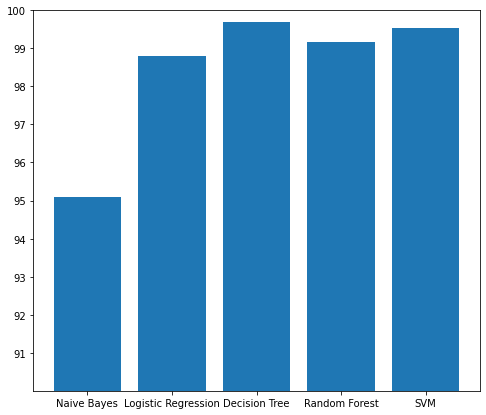

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))